در حال دریافت داده‌های قیمت دارایی‌ها، دلار و شاخص کل...


C:\Users\a.kamrani\AppData\Roaming\Python\Python312\site-packages\finpy_tse\__init__.py:424: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_history = pd.concat([df_history,df_temp])
C:\Users\a.kamrani\AppData\Roaming\Python\Python312\site-packages\finpy_tse\__init__.py:424: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_history = pd.concat([df_history,df_temp])
C:\Users\a.kamrani\AppData\Roaming\Python\Python312\site-packages\finpy_tse\__init__.py:424: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future ve


🎯 مشخصات سبد بهینه (Optimal Portfolio - Max Sharpe Ratio)
-------------------------------------------------------
  فولاد: 4.02%
  شپنا: 19.82%
  شتران: 0.96%
  طلا: 29.86%
  ثبات: 16.54%
  اخابر: 0.09%
  خودرو: 1.21%
  Dollar: 27.49%
------------------------------
  بازده سالانه مورد انتظار: 53.51%
  ریسک (انحراف معیار) سالانه: 22.17%
  نسبت شارپ: 1.06


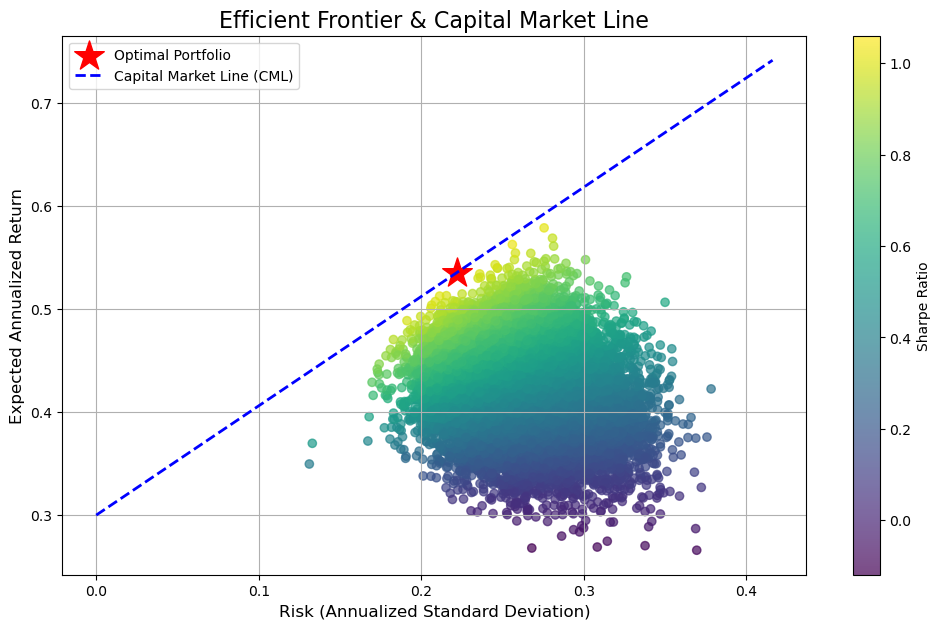


در حال تولید نمودارهای تحلیلی بیشتر...


C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


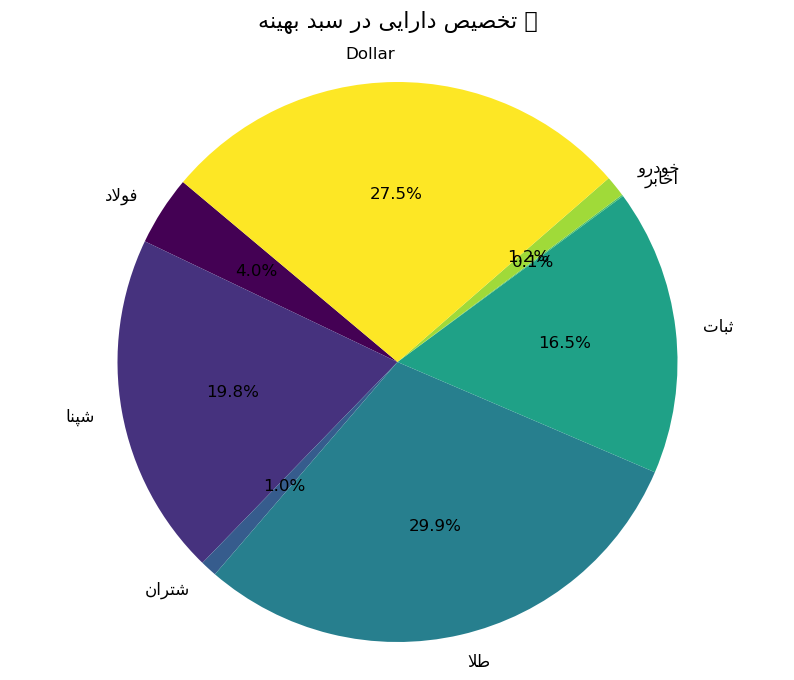

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


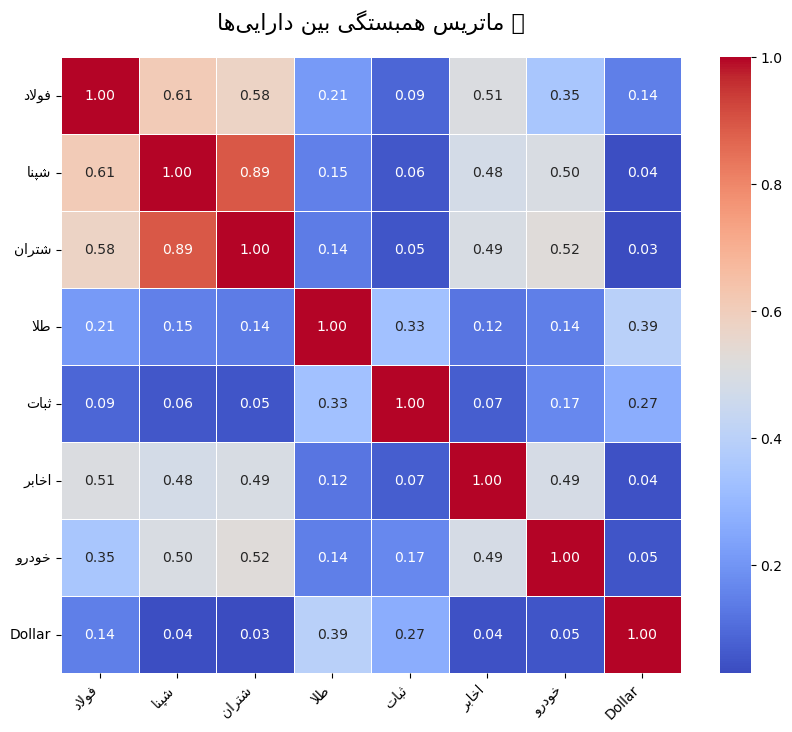

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


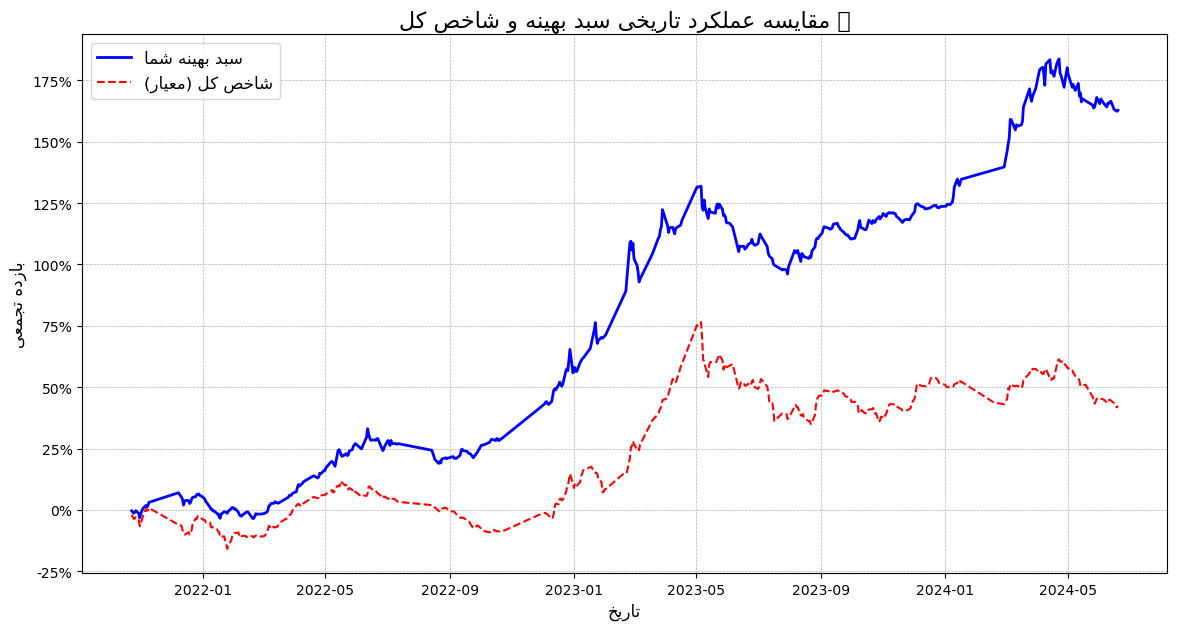


💵 لطفاً نرخ روز دلار به ریال را وارد کنید:  875000
✅ لطفاً کل مبلغ سرمایه‌گذاری خود را به دلار وارد کنید:  1000



💰 تخصیص سبد برای سرمایه 1,000.00 دلاری
با فرض نرخ دلار: 875,000 ریال | مبلغ کل: 875,000,000 ریال
-------------------------------------------------------
  📊 تخصیص به فولاد: 35,176,243 ریال
  📊 تخصیص به شپنا: 173,460,464 ریال
  📊 تخصیص به شتران: 8,421,939 ریال
  📊 تخصیص به طلا: 261,303,026 ریال
  📊 تخصیص به ثبات: 144,734,160 ریال
  📊 تخصیص به اخابر: 764,918 ریال
  📊 تخصیص به خودرو: 10,601,691 ریال
  📊 تخصیص به Dollar: 240,537,560 ریال


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import finpy_tse as fpy
import jdatetime

# کتابخانه‌های جدید برای حل مشکل فارسی در نمودارها
import arabic_reshaper
from bidi.algorithm import get_display

# =============================================================================
# تابع کمکی برای اصلاح نمایش متن فارسی فقط در نمودارها
# =============================================================================
def fix_persian_text(text):
    """
    متن فارسی را برای نمایش صحیح در نمودارهای Matplotlib آماده می‌کند.
    """
    reshaped_text = arabic_reshaper.reshape(str(text))
    bidi_text = get_display(reshaped_text)
    return bidi_text

# =============================================================================
# توابع دریافت داده
# =============================================================================
def jalali_to_gregorian_converter(jalali_date):
    try:
        jalali_date_obj = jdatetime.date(*map(int, jalali_date.split('-')))
        return jalali_date_obj.togregorian().strftime('%Y-%m-%d')
    except:
        return None

def get_price_data(tickers, start_date, end_date):
    price_df = pd.DataFrame()
    for ticker in tickers:
        try:
            df = fpy.Get_Price_History(stock=ticker, start_date=start_date, end_date=end_date, ignore_date=False, adjust_price=True)
            if 'Adj Close' in df.columns:
                price_df[ticker] = df['Adj Close']
            else:
                print(f"⚠️ قیمت تعدیل‌شده برای {ticker} یافت نشد.")
        except Exception as e:
            print(f"خطا در دریافت داده {ticker}: {e}")
    price_df.index = price_df.index.map(jalali_to_gregorian_converter)
    price_df.index = pd.to_datetime(price_df.index)
    return price_df.dropna()

def get_usd_data(start_date, end_date):
    try:
        df = fpy.Get_USD_RIAL(start_date=start_date, end_date=end_date)
        df.index = df.index.map(jalali_to_gregorian_converter)
        df.index = pd.to_datetime(df.index)
        return df[['Close']].rename(columns={'Close': 'Dollar'})
    except Exception as e:
        print(f"خطا در دریافت قیمت دلار: {e}")
        return pd.DataFrame()

def get_benchmark_data(start_date, end_date):
    try:
        df = fpy.Get_CWI_History(start_date=start_date, end_date=end_date)
        df.index = df.index.map(jalali_to_gregorian_converter)
        df.index = pd.to_datetime(df.index)
        return df[['Adj Close']].rename(columns={'Adj Close': 'Benchmark'})
    except Exception as e:
        print(f"خطا در دریافت داده شاخص کل: {e}")
        return pd.DataFrame()

# =============================================================================
# تابع شبیه‌سازی مونت‌کارلو
# =============================================================================
def run_monte_carlo_simulation(daily_returns, num_portfolios=20000, risk_free_rate=0.3):
    num_assets = len(daily_returns.columns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    mean_returns = daily_returns.mean() * 252
    cov_matrix = daily_returns.cov() * 252

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        port_return = np.sum(mean_returns * weights)
        port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        results[0, i] = port_return
        results[1, i] = port_std
        results[2, i] = (port_return - risk_free_rate) / (port_std + 1e-8)

    return results, weights_record

# =============================================================================
# توابع مصورسازی (ویژوال‌سازی)
# =============================================================================
def plot_asset_allocation(weights, tickers):
    plt.figure(figsize=(10, 8))
    fixed_labels = [fix_persian_text(t) for t in tickers]
    colors = plt.cm.viridis(np.linspace(0, 1, len(tickers)))
    plt.pie(weights, labels=fixed_labels, autopct='%1.1f%%', startangle=140, colors=colors, textprops={'fontsize': 12})
    plt.title(fix_persian_text('📊 تخصیص دارایی در سبد بهینه'), fontsize=16, pad=20)
    plt.axis('equal')
    plt.show()

def plot_correlation_heatmap(daily_returns):
    corr_matrix = daily_returns.corr()
    fixed_columns = [fix_persian_text(col) for col in corr_matrix.columns]
    corr_matrix.columns = fixed_columns
    corr_matrix.index = fixed_columns
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(fix_persian_text('🔗 ماتریس همبستگی بین دارایی‌ها'), fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

def plot_backtest_performance(portfolio_returns, benchmark_returns):
    portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1

    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label=fix_persian_text('سبد بهینه شما'), color='blue', linewidth=2)
    plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label=fix_persian_text('شاخص کل (معیار)'), color='red', linestyle='--')
    
    plt.title(fix_persian_text('📈 مقایسه عملکرد تاریخی سبد بهینه و شاخص کل'), fontsize=16)
    plt.xlabel(fix_persian_text('تاریخ'), fontsize=12)
    plt.ylabel(fix_persian_text('بازده تجمعی'), fontsize=12)
    plt.legend(prop={'size': 12})
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.show()

# =============================================================================
# توابع تحلیلی و نمایش خروجی
# =============================================================================
def analyze_and_plot_efficient_frontier(results, weights_record, tickers, rf):
    results_df = pd.DataFrame(results.T, columns=['Return', 'Risk', 'Sharpe_Ratio'])
    max_sharpe_idx = results_df['Sharpe_Ratio'].idxmax()
    optimal_portfolio = results_df.iloc[max_sharpe_idx]
    optimal_weights = weights_record[max_sharpe_idx]

    # نمایش در ترمینال - بدون نیاز به تابع اصلاح
    print("\n" + "="*55)
    print("🎯 مشخصات سبد بهینه (Optimal Portfolio - Max Sharpe Ratio)")
    print("-" * 55)
    for i, ticker in enumerate(tickers):
        print(f"  {ticker}: {optimal_weights[i]:.2%}")
    print("-" * 30)
    print(f"  بازده سالانه مورد انتظار: {optimal_portfolio['Return']:.2%}")
    print(f"  ریسک (انحراف معیار) سالانه: {optimal_portfolio['Risk']:.2%}")
    print(f"  نسبت شارپ: {optimal_portfolio['Sharpe_Ratio']:.2f}")
    print("="*55)
    
    # نمودار مرز کارا با عناوین انگلیسی
    plt.figure(figsize=(12, 7))
    scatter = plt.scatter(results_df['Risk'], results_df['Return'], c=results_df['Sharpe_Ratio'], cmap='viridis', marker='o', alpha=0.7)
    plt.colorbar(scatter, label='Sharpe Ratio')
    plt.scatter(optimal_portfolio['Risk'], optimal_portfolio['Return'], color='red', marker='*', s=500, label='Optimal Portfolio')
    x_vals = np.linspace(0, results_df['Risk'].max() * 1.1, 100)
    cml_y = rf + optimal_portfolio['Sharpe_Ratio'] * x_vals
    plt.plot(x_vals, cml_y, linestyle='--', color='blue', linewidth=2, label='Capital Market Line (CML)')
    plt.title('Efficient Frontier & Capital Market Line', fontsize=16)
    plt.xlabel('Risk (Annualized Standard Deviation)', fontsize=12)
    plt.ylabel('Expected Annualized Return', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.show()

    return optimal_weights

def display_investment_allocation(total_capital_usd, usd_irr_rate, optimal_weights, tickers):
    total_capital_irr = total_capital_usd * usd_irr_rate
    # نمایش در ترمینال - بدون نیاز به تابع اصلاح
    print("\n" + "="*55)
    print(f"💰 تخصیص سبد برای سرمایه {total_capital_usd:,.2f} دلاری")
    print(f"با فرض نرخ دلار: {usd_irr_rate:,.0f} ریال | مبلغ کل: {total_capital_irr:,.0f} ریال")
    print("-"*55)
    for i, ticker in enumerate(tickers):
        amount_to_invest = total_capital_irr * optimal_weights[i]
        print(f"  📊 تخصیص به {ticker}: {amount_to_invest:,.0f} ریال")
    print("="*55)

# =============================================================================
# ---------- اجرای اصلی برنامه ----------
# =============================================================================
if __name__ == '__main__':
    # --- پارامترهای ورودی ---
    tickers = ['فولاد', 'شپنا', 'شتران', 'طلا', 'ثبات', 'اخابر', 'خودرو']
    start_date = '1400-01-01'
    end_date = '1403-04-01'
    risk_free_rate_annual = 0.30

    print("در حال دریافت داده‌های قیمت دارایی‌ها، دلار و شاخص کل...")
    
    stock_data = get_price_data(tickers, start_date, end_date)
    usd_data = get_usd_data(start_date, end_date)
    benchmark_data = get_benchmark_data(start_date, end_date)
    
    all_data_list = [stock_data]
    if not usd_data.empty:
        all_data_list.append(usd_data)
        
    asset_data = pd.concat(all_data_list, axis=1, join='inner').dropna()

    if asset_data.empty or len(asset_data) < 2:
        print("خطا: داده مشترکی برای دارایی‌ها یافت نشد. تحلیل متوقف شد.")
    else:
        full_data = pd.merge(asset_data, benchmark_data, left_index=True, right_index=True, how='inner')
        asset_daily_returns = full_data[asset_data.columns].pct_change().dropna()
        benchmark_daily_returns = full_data['Benchmark'].pct_change().dropna()
        
        common_idx = asset_daily_returns.index.intersection(benchmark_daily_returns.index)
        asset_daily_returns = asset_daily_returns.loc[common_idx]
        benchmark_daily_returns = benchmark_daily_returns.loc[common_idx]
        
        asset_tickers = asset_daily_returns.columns.tolist()

        results, weights = run_monte_carlo_simulation(asset_daily_returns, risk_free_rate=risk_free_rate_annual)
        
        # این تابع نتایج را در ترمینال چاپ و نمودار مرز کارا را رسم می‌کند
        optimal_weights = analyze_and_plot_efficient_frontier(results, weights, asset_tickers, rf=risk_free_rate_annual)

        print("\nدر حال تولید نمودارهای تحلیلی بیشتر...")
        
        # این توابع نمودارهای جدید را با متن فارسی صحیح نمایش می‌دهند
        plot_asset_allocation(optimal_weights, asset_tickers)
        plot_correlation_heatmap(asset_daily_returns)
        portfolio_daily_returns = (asset_daily_returns * optimal_weights).sum(axis=1)
        plot_backtest_performance(portfolio_daily_returns, benchmark_daily_returns)
        
        # ورودی از کاربر - بدون نیاز به تابع اصلاح
        try:
            manual_usd_rate = float(input("\n💵 لطفاً نرخ روز دلار به ریال را وارد کنید: "))
            capital_input = float(input("✅ لطفاً کل مبلغ سرمایه‌گذاری خود را به دلار وارد کنید: "))
            
            # این تابع نتایج نهایی را در ترمینال چاپ می‌کند
            display_investment_allocation(capital_input, manual_usd_rate, optimal_weights, asset_tickers)
        except ValueError:
            print("خطا: لطفاً برای نرخ دلار و مبلغ سرمایه، یک عدد معتبر وارد کنید.")